In [2]:
import pandas as pd
import numpy as np
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('tourist_data_with_ratings.csv')

In [4]:
# Aggregating duplicate ratings by taking their average

df = df.groupby(['User_ID', 'Attraction']).agg({'User_Rating': 'mean'}).reset_index()


In [5]:
num_users = df['User_ID'].nunique()  
num_items = df['Attraction'].nunique()

user_item_matrix = df.pivot(index='User_ID', columns='Attraction', values='User_Rating').fillna(0).values
user_item_matrix = csr_matrix(user_item_matrix)

In [6]:
print(user_item_matrix)

  (0, 32)	3.680583206608363
  (0, 36)	2.56623715908795
  (0, 67)	2.672769056447677
  (0, 144)	2.757980258443021
  (0, 217)	2.493439008912098
  (0, 230)	2.847103227588438
  (0, 329)	1.8000402793169787
  (0, 414)	2.4759714091136207
  (0, 483)	5.0
  (0, 502)	2.5297232160641627
  (0, 648)	4.120148780415464
  (0, 701)	2.6058585611948226
  (0, 886)	2.562997486637617
  (0, 925)	4.071031464397147
  (0, 932)	3.3071724041752706
  (0, 1041)	3.874779752192804
  (0, 1080)	3.846527018313001
  (0, 1105)	3.726570963684408
  (0, 1134)	2.565444939718079
  (0, 1175)	3.8589175837406593
  (0, 1177)	3.468864461684724
  (0, 1201)	1.688433168186104
  (0, 1261)	3.928821006012148
  (0, 1272)	1.704670915262933
  (0, 1299)	3.1729265691362136
  :	:
  (199, 5174)	4.286372186780072
  (199, 5182)	3.5540149927017453
  (199, 5275)	3.3273708231139105
  (199, 5279)	4.954003682472759
  (199, 5292)	5.0
  (199, 5309)	4.228172749547217
  (199, 5346)	3.150194601870789
  (199, 5390)	2.6498665892153648
  (199, 5396)	4.811831562

In [7]:
# Applying Truncated SVD for dimensionality reduction
n_components = 25  # Reduced number of latent factors for efficiency
svd = TruncatedSVD(n_components=n_components, random_state=42)
user_item_reduced = svd.fit_transform(user_item_matrix)


In [8]:
# Reconstructing the user-item matrix
user_item_approx = svd.inverse_transform(user_item_reduced)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(user_item_matrix.toarray(), user_item_approx, test_size=0.2, random_state=42)


In [10]:
y_pred = X_test

In [11]:
rmse_svd = np.sqrt(mean_squared_error(y_test, y_pred))
mae_svd = mean_absolute_error(y_test, y_pred)
r2_svd = r2_score(y_test, y_pred)

print(f"Collaborative Filtering with Truncated SVD - RMSE: {rmse_svd:.4f}")
print(f"Collaborative Filtering with Truncated SVD - MAE: {mae_svd:.4f}")
print(f"Collaborative Filtering with Truncated SVD - R^2 Score: {r2_svd:.4f}")

Collaborative Filtering with Truncated SVD - RMSE: 0.5156
Collaborative Filtering with Truncated SVD - MAE: 0.2281
Collaborative Filtering with Truncated SVD - R^2 Score: -5.1043


In [12]:
def recommend_items(user_preferences, df, svd, num_recommendations=5):
    user_latent = svd.transform([user_preferences])
    
    # Reconstructing user-item interactions from latent factors
    user_approx_ratings = svd.inverse_transform(user_latent).flatten()
    
    recommendations = pd.DataFrame({'item': df['Attraction'].unique(), 'predicted_rating': user_approx_ratings})
    
    recommended_items = recommendations.sort_values(by='predicted_rating', ascending=False).head(num_recommendations)
    return recommended_items

user_preferences = [np.random.uniform(0, 5) for _ in range(num_items)]

top_recommended_items = recommend_items(user_preferences, df, svd)

print("\nTop Recommended Tourist Attractions for You:")
print(top_recommended_items[['item', 'predicted_rating']])


Top Recommended Tourist Attractions for You:
                                           item  predicted_rating
2549                    Boyne Valley Activities          7.458201
5182  Bunk Campers Motorhome and Campervan Hire          5.326866
5515        All Ireland Chauffeur - Coach Tours          4.730874
1186                       Orso Kitchen and Bar          4.580959
723                            Ballyhack Castle          4.497652


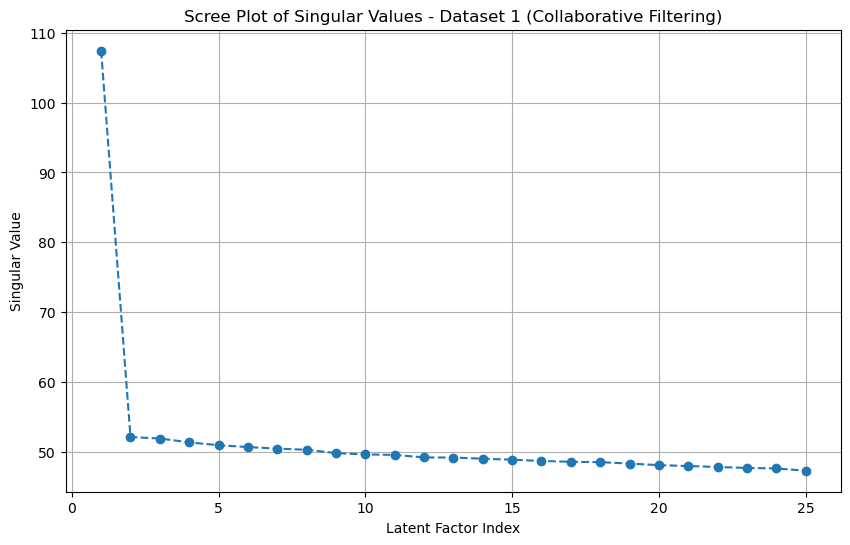

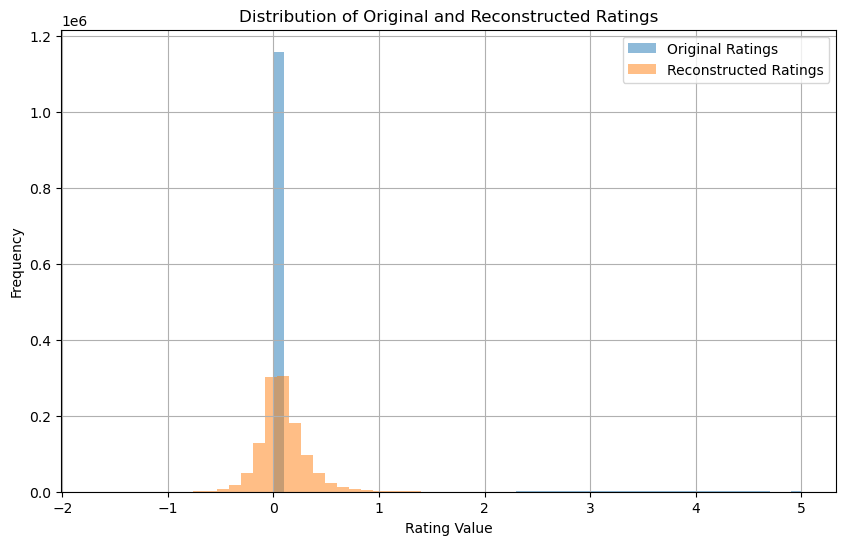

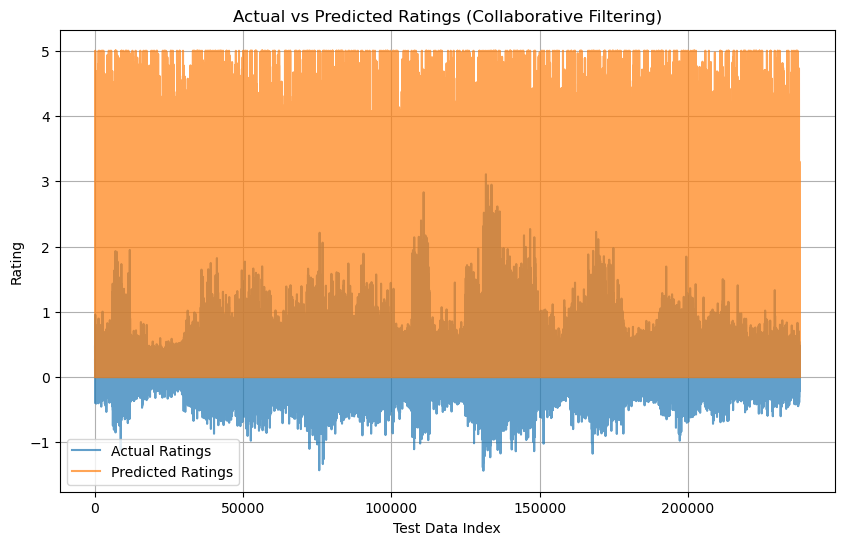

In [20]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, n_components + 1), svd.singular_values_, marker='o', linestyle='--')
plt.xlabel('Latent Factor Index')
plt.ylabel('Singular Value')
plt.title('Scree Plot of Singular Values - Dataset 1 (Collaborative Filtering)')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.hist(user_item_matrix.toarray().flatten(), bins=50, alpha=0.5, label='Original Ratings')
plt.hist(user_item_approx.flatten(), bins=50, alpha=0.5, label='Reconstructed Ratings')
plt.xlabel('Rating Value')
plt.ylabel('Frequency')
plt.title('Distribution of Original and Reconstructed Ratings')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
x_values = range(len(y_test.flatten()))
plt.plot(x_values, y_test.flatten(), label='Actual Ratings', alpha=0.7)
plt.plot(x_values, y_pred.flatten(), label='Predicted Ratings', alpha=0.7)
plt.xlabel('Test Data Index')
plt.ylabel('Rating')
plt.title('Actual vs Predicted Ratings (Collaborative Filtering)')
plt.legend()
plt.grid(True)
plt.show()